In [1]:
import logging

logging.basicConfig(
    filename="model.log",
    format="%(asctime)s %(message)s",
    filemode="w"
)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB # For binary features
from sklearn.metrics import f1_score, confusion_matrix as cm
from sklearn.model_selection import GridSearchCV
from dotenv import  get_key, set_key
logger.info("[New Session Created]")


## Extracting Datasets from Files

In [3]:
def load_data(train, test, valid_labels):
    features = set()
    train_m = 0
    test_m = 0

    train_dataset = np.zeros(shape=(1000, 100002))
    test_dataset = np.zeros(shape=(1000, 100002))

    with open(train) as f:
        for i, line in enumerate(f):
            train_m += 1
            
            l = line.strip().split('\t')

            train_dataset[i, 0] = int(l[0])
            # features set for later deletion null
            for x in l[1].split():
                features.add(int(x))
                train_dataset[i ,int(x) + 1] = 1

    test_labels = []
    with open(valid_labels) as f:
        for line in f:
            test_labels.append(int(line.strip()))

    with open(test) as f:
        for i, line in enumerate(f):
            test_m += 1
            
            test_dataset[i, 0] = int(test_labels[i])

            #  features set for later deleting null
            for x in line.strip().split():
                features.add(int(x))
                test_dataset[i ,int(x) + 1] = 1




    # cleaning dataset a bit
    train_dataset = np.delete(train_dataset,slice(train_m, 1000), 0)
    test_dataset = np.delete(test_dataset,slice(test_m, 1000), 0)

    not_features = {x for x in range(10000)} - features

    not_features = list(map(lambda x: x+1, not_features))
    
    
    train_dataset = np.delete(train_dataset,not_features, 1)
    test_dataset = np.delete(test_dataset,not_features, 1)    

    return train_dataset, test_dataset       


## Loading Datasets

In [4]:
train_data, test_data = load_data('train.dat', 'test.dat', 'valid_labels.dat')

train_x, train_y = train_data[:, 1:], train_data[:, 0]
test_x, test_y = test_data[:, 1:], test_data[:, 0]

test_data[2, 0]
logger.info("Loaded Dataset")


## The Pipeline

In [5]:
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('bnb', BernoulliNB())  
    ]
)

logger.info("Created Pipeline")

## Search for Best Hyperparameter

    The only hyper parameter of this model is number of components, n_components, in the principle component analysis step of the pipe line.
    Tuning and finding a better value increases the f1 score of the model.  

    This process takes time as performing pca on large number of feature takes time and it is step that consumes large amount of time 
    during training.

### Linearly Search for hyper parameter

In [15]:

best_score = 0.0
pca_params = [490, 500, 501, 502, 510, 549, 550 ]

msg = "Started Linear search for hyper parameter: \n"
for pca_param in pca_params:
    pipe.set_params(pca__n_components=pca_param)
    pipe.fit(train_x, train_y)
    if f1_score(train_y, pipe.predict(train_x)) > best_score:
        msg += "\t\t\t\tBetter parameter found for pca__n_components {}, score : {}\n".format(pca_param, pipe.score(train_x, train_y))
        best_pca_param = pca_param
        best_score = pipe.score(train_x, train_y)
logger.info(msg)


### Using GridSearchCV

In [16]:
logger.info("Started Grid Search CV")
cv_search = GridSearchCV(
    pipe, 
    param_grid={
        "pca__n_components" : pca_params,
    },
    scoring="f1"
)

cv_search.fit(train_x, train_y)
logger.info("Finished Grid Search CV, The best score is found to be {} for parameter {}".format(cv_search.best_score_, cv_search.best_params_['pca__n_components']))


In [17]:
record = pd.DataFrame(cv_search.cv_results_)
record.to_csv("Last_train_record.csv")
logger.info("The Search Reusults are recorded in the csv file '.\\Last_train_record.csv'")


In [18]:
record.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,31.813814,0.722734,0.427698,0.024493,490,{'pca__n_components': 490},0.538462,0.482759,0.709677,0.571429,0.800000,0.620465,0.116862,3
1,32.613911,0.748980,0.453176,0.059361,500,{'pca__n_components': 500},0.500000,0.482759,0.687500,0.571429,0.838710,0.616079,0.132595,5
2,32.205938,0.765549,0.416287,0.023044,501,{'pca__n_components': 501},0.480000,0.466667,0.727273,0.620690,0.812500,0.621426,0.135399,2
3,33.176822,0.807912,0.451805,0.022107,502,{'pca__n_components': 502},0.480000,0.466667,0.709677,0.600000,0.838710,0.619011,0.140984,4
4,31.972912,0.577439,0.432250,0.032379,510,{'pca__n_components': 510},0.538462,0.482759,0.666667,0.620690,0.848485,0.631412,0.125870,1


## Making Prediction

In [19]:
best_param = cv_search.best_params_['pca__n_components']
pipe.set_params(pca__n_components=best_param)
pipe.fit(train_x, train_y)

y_pred_test = pipe.predict(test_x)


score = f1_score( test_y, y_pred_test)

if score < float(get_key('./.env','OVERALL_BEST_SCORE')):
    best_param = int(get_key('./.env','OVERALL_BEST_PARAM'))
    pipe.set_params(pca__n_components=best_param)
    pipe.fit(train_x, train_y)
    score = float(get_key('./.env','OVERALL_BEST_SCORE'))

else:
    set_key('./.env', 'OVERALL_BEST_SCORE', score)
    set_key('./.env', 'OVERALL_BEST_PARAM', best_param) 

    
print("F1 Score :", score)
logger.info("The F1 Score of the model : {}, for pca__n_components {}".format(score, best_param))



F1 Score : 0.71875


## Plotting Results

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt

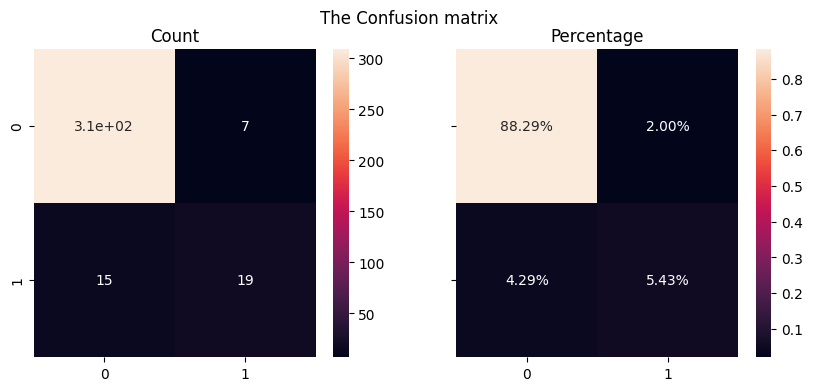

In [14]:
confusion_matrix_test = cm(test_y, y_pred_test)


group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts_test = ["{0:0.0f}".format(val) for val in confusion_matrix_test.flatten()]
group_counts_test = ["{0:0.0f}".format(val) for val in confusion_matrix_test.flatten()/test_y.shape[0]]



fig, axes = plt.subplots(1,2, sharex= True, sharey=True, figsize=(10, 4))
fig.suptitle("The Confusion matrix")


axes[0].set_title("Count")

sns.heatmap(
    confusion_matrix_test,
    ax=axes[0],
    annot=True,
)


axes[1].set_title("Percentage")

sns.heatmap(
    confusion_matrix_test/test_y.shape[0],
    ax=axes[1],
    fmt=".2%",
    annot=True,
)

plt.show()